In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json
import requests
import random
import deva

In [3]:
cptac.download(dataset='Ovarian')

ov = cptac.Ovarian()
proteomics = ov.get_proteomics()
transcriptomics = ov.get_transcriptomics()
clinical = ov.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [24]:
columns_to_explore = ['Participant_History_Malignancy', 
                      'Sample_Tumor_Normal']

#Create a subsetted copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical[columns_to_explore].copy())

## Step 3: Perform Outlier Analysis
Using the Blacksheep-outliers package, deva, we will create two tables: one of all the significant up-regulated genes per patient (which we will call outliers), and one of the q-values for significantly enriched genes based on our binarized clinical attributes (which we will call qvalues).

In [32]:
outliers, qvalues = deva.run_outliers(proteomics.transpose(), 
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False)

09/03/2019 15:00:17:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S092, S099, S105, S109, S086, continuing without them. 
09/03/2019 15:00:17:WARNING:No rows tested for fisherFDR_Participant_History_Malignancy_No
09/03/2019 15:00:18:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S086, S092, S099, S105, S109, continuing without them. 
09/03/2019 15:00:18:WARNING:No rows tested for fisherFDR_Sample_Tumor_Normal_Tumor


In [33]:
outliers_down, qvalues_down = deva.run_outliers(proteomics.transpose(), 
                                                annotations, 
                                                up_or_down='down', 
                                                aggregate=False)

09/03/2019 15:00:36:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S092, S099, S105, S109, S086, continuing without them. 
09/03/2019 15:00:36:WARNING:No rows tested for fisherFDR_Participant_History_Malignancy_No
09/03/2019 15:00:37:WARNING:These samples were not found in outliers table: S001, S003, S004, S005, S008, S010, S014, S017, S018, S020, S021, S030, S032, S034, S036, S058, S072, S073, S075, S077, S081, S082, S083, S086, S092, S099, S105, S109, continuing without them. 
09/03/2019 15:00:37:WARNING:No rows tested for fisherFDR_Sample_Tumor_Normal_Tumor


In [27]:
length = int(len(outliers.df.columns) / 2)
temp_outliers = outliers.df.transpose()
only_outliers_up = temp_outliers[:length]
outliers_up_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_up_dict[key] = value

In [28]:
length = int(len(outliers_down.df.columns) / 2)
temp_outliers_down = outliers_down.df.transpose()
only_outliers_down = temp_outliers_down[:length]
outliers_down_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_down.iloc[i] == 1.0
    value = list(only_outliers_down.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_down_dict[key] = value

## Step 4: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [19]:
#Drop Columns with less than 4 significant up-regulated enrichments
sig_cols_up = []
for col in qvalues.df.columns:
    sig_col = bf.significantEnrichments(qvalues.df, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_up.append(sig_col)
    else:
        results_up = qvalues.df.drop(col, axis=1)

In [20]:
#Drop Columns with less than 4 significant down-regulated enrichments
sig_cols_down = []
for col in qvalues_down.df.columns:
    sig_col = bf.significantEnrichments(qvalues_down.df, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_down.append(sig_col)
    else:
        results_down = qvalues_down.df.drop(col, axis=1)

In [21]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols_up):
    list_of_genes = list(col.index.get_level_values('Name'))
    sig_genes_up[sig_cols_up[i].columns[0][:-9]] = list_of_genes   

In [22]:
#And then down-regulated genes
sig_genes_down = {}
for i, col in enumerate(sig_cols_down):
    list_of_genes = list(col.index.get_level_values('Name'))
    sig_genes_down[sig_cols_down[i].columns[0][:-9]] = list_of_genes

In [23]:
#Simple visualization
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


NameError: name 'results_up' is not defined

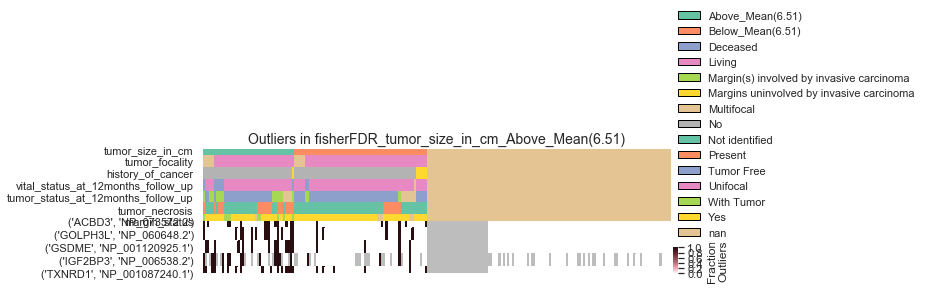

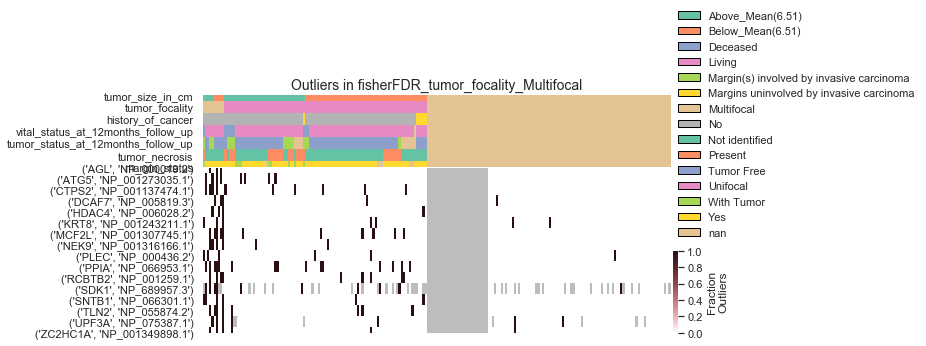

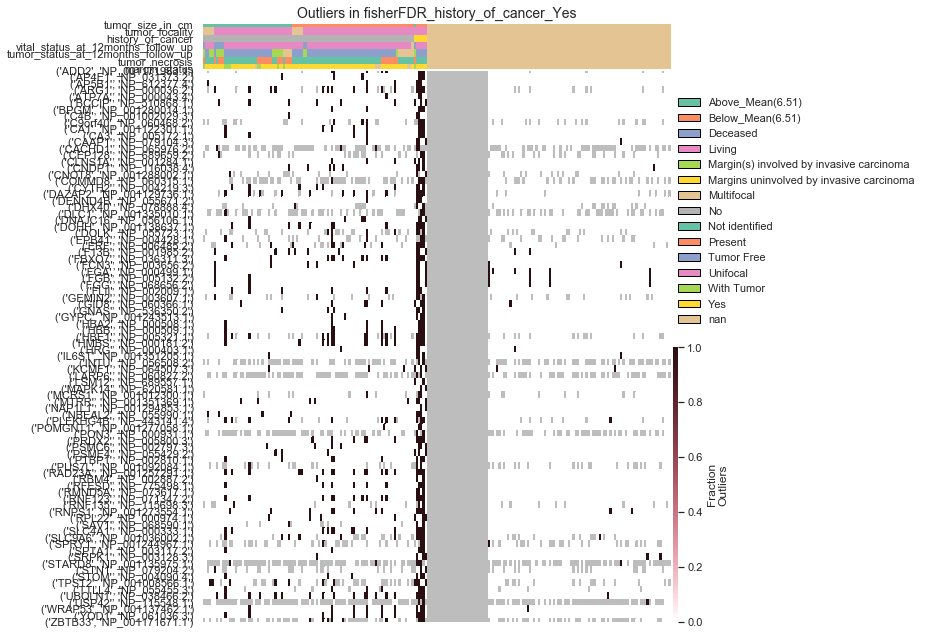

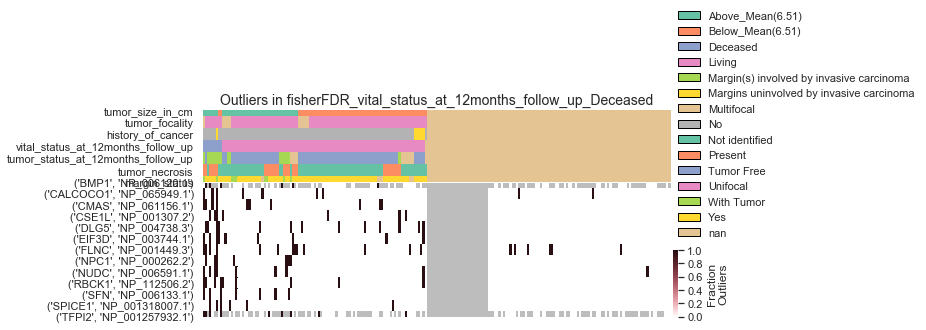

09/03/2019 12:16:52:WARNING:No significant genes at FDR 0.05 in fisherFDR_tumor_status_at_12months_follow_up_Tumor Free


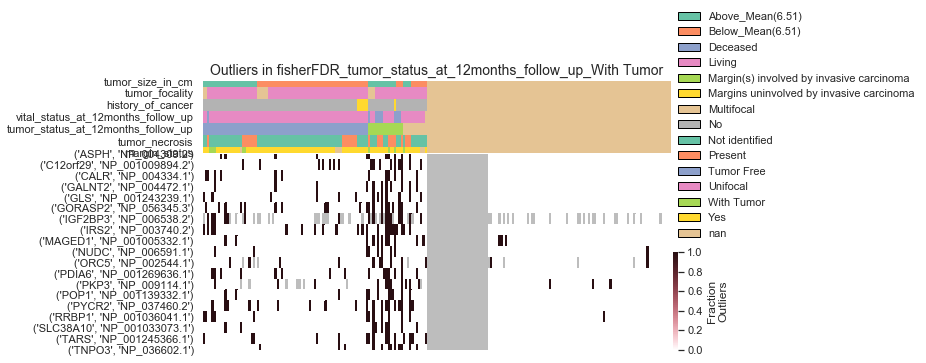

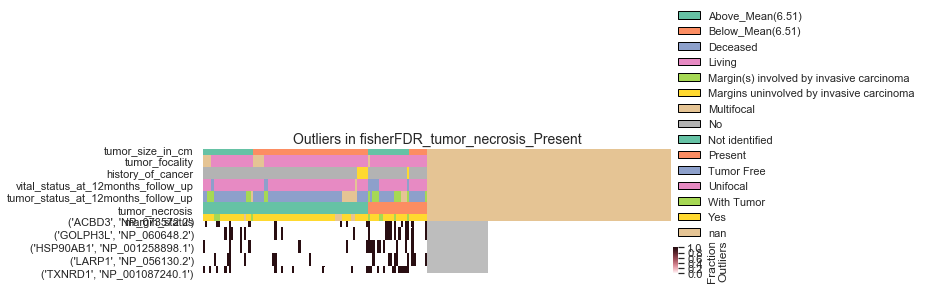

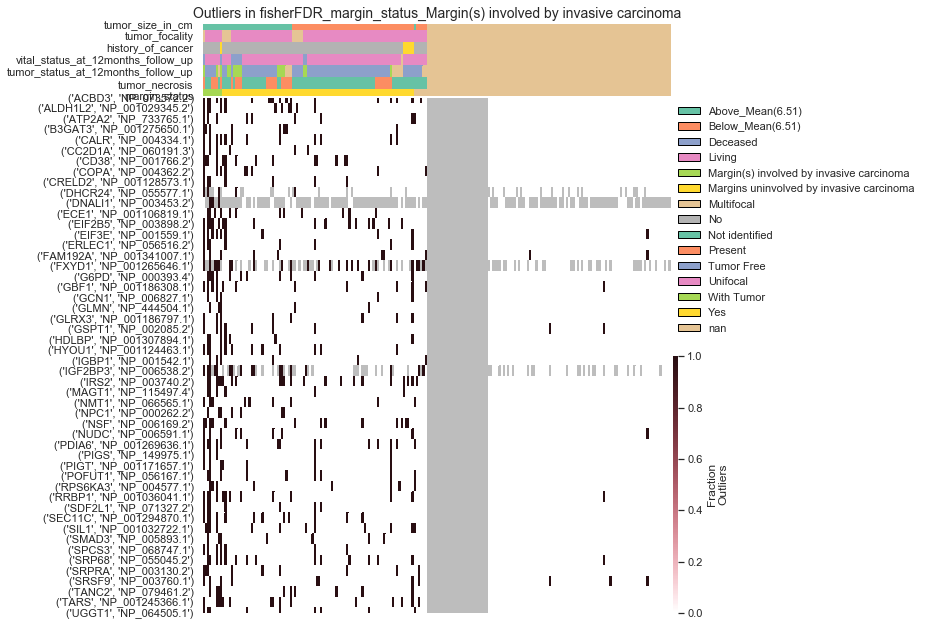

In [13]:
#Deva package visualization
for col in qvalues.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues.df,
    col_of_interest=col,
    vis_table=outliers.frac_table)
    
    plt.show()
    plt.close()

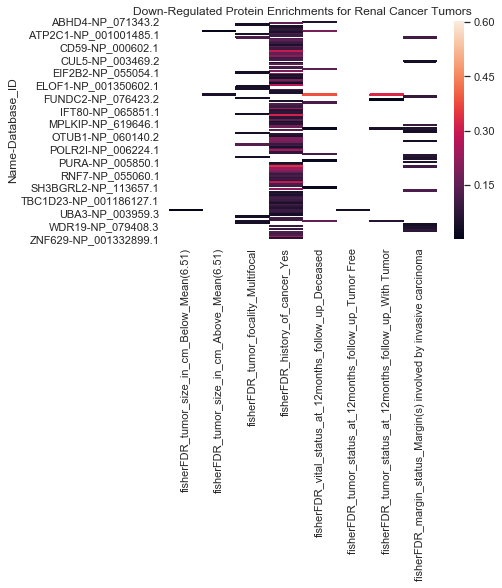

In [14]:
ax2 = plt.axes()
sns.heatmap(results_down, ax = ax2)
ax2.set_title('Down-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

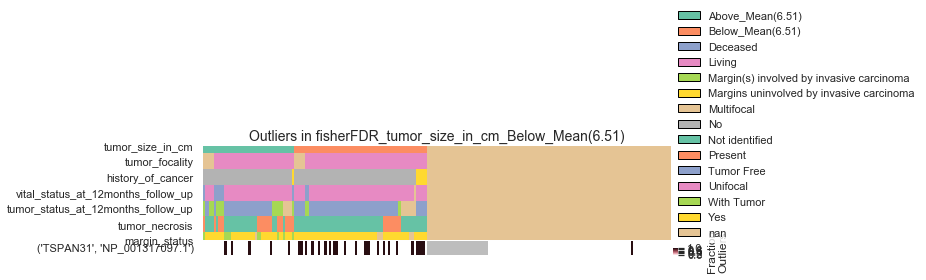

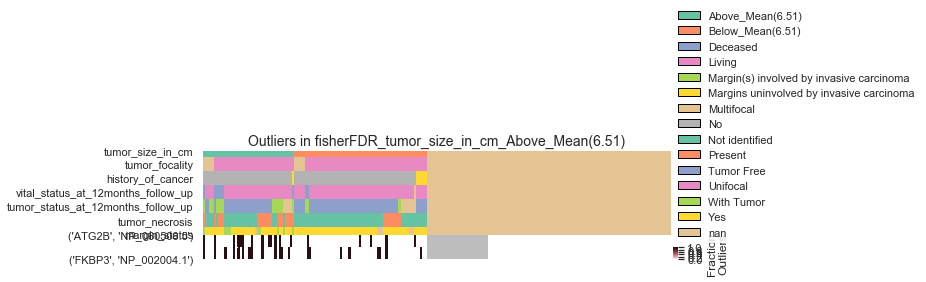

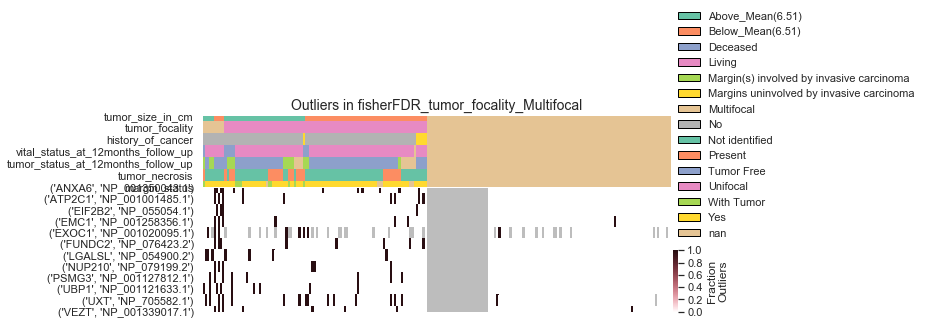

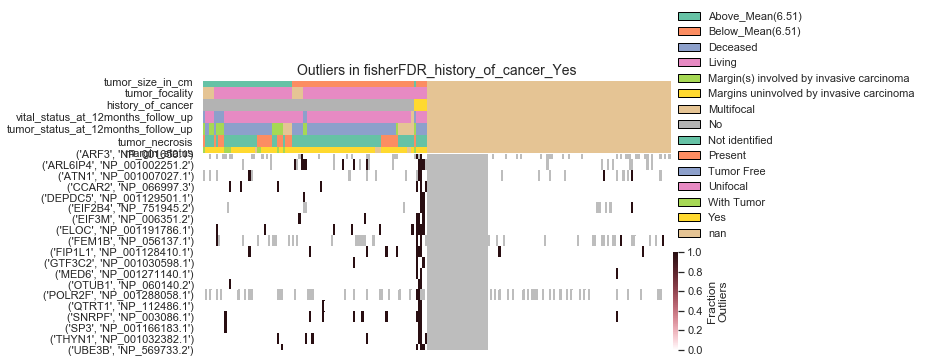

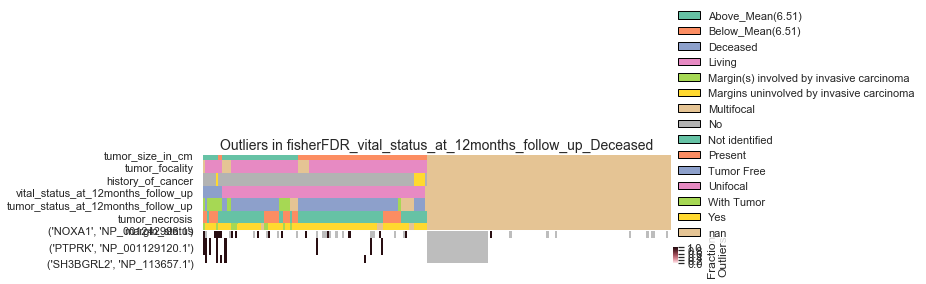

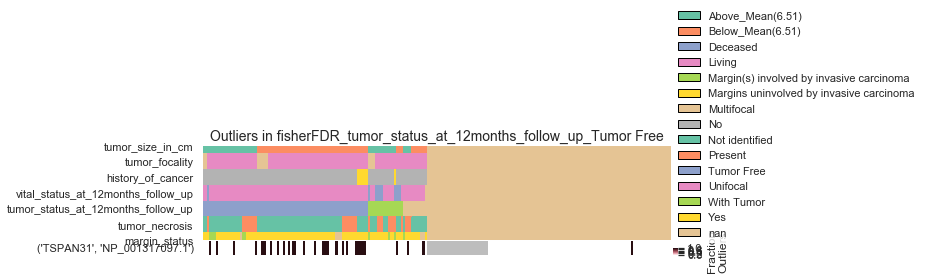

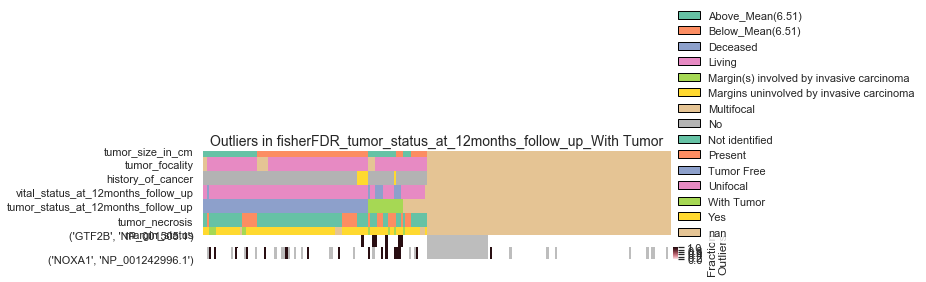

09/03/2019 12:17:08:WARNING:No significant genes at FDR 0.05 in fisherFDR_tumor_necrosis_Not identified


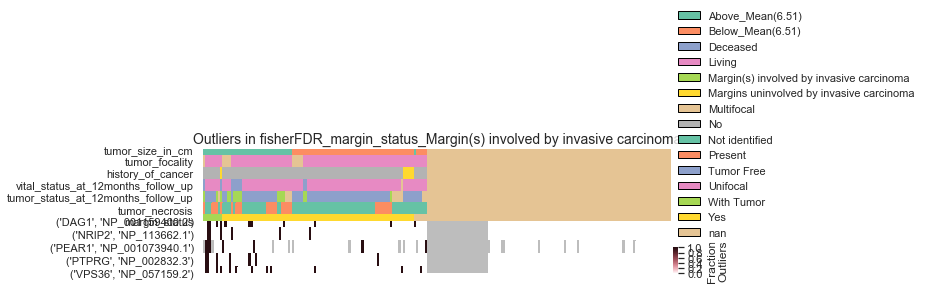

In [15]:
#Deva package visualization
for col in qvalues_down.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues_down.df,
    col_of_interest=col,
    vis_table=outliers_down.frac_table)
    
    plt.show()
    plt.close()

## Step 5: Perform Gene Set Enrichment Analysis

Part A: Up-regulated Genes

In [16]:
gsea_up = {}
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join(col_name.split(" "))
    print(col_name[:-9])
    gene_name_list = list(col.index.get_level_values('Name'))
    print('Gene List:', gene_name_list, '\n')
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    gsea_up[col_name] = enrichment
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

fisherFDR_tumor_size_in_cm_Above_Mean(6.51)
Gene List: ['ACBD3', 'GOLPH3L', 'GSDME', 'IGF2BP3', 'TXNRD1'] 



2019-09-03 12:17:12,502 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/03/2019 12:17:12:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_tumor_focality_Multifocal
Gene List: ['AGL', 'ATG5', 'CTPS2', 'DCAF7', 'HDAC4', 'KRT8', 'MCF2L', 'NEK9', 'PLEC', 'PPIA', 'RCBTB2', 'SDK1', 'SNTB1', 'TLN2', 'UPF3A', 'ZC2HC1A'] 



2019-09-03 12:17:15,420 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/03/2019 12:17:15:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_history_of_cancer_Yes
Gene List: ['ADD2', 'AP4E1', 'AP5B1', 'ARG1', 'ATP7A', 'BCCIP', 'BPGM', 'C4B', 'C9orf40', 'CA1', 'CA3', 'CAAP1', 'CACHD1', 'CEP128', 'CLNS1A', 'CNDP1', 'CNOT8', 'COMMD8', 'CYTH2', 'DAZAP2', 'DENND4B', 'DHX40', 'DLC1', 'DNAJC16', 'DOHH', 'DOLK', 'EPB41', 'ERF', 'F13B', 'FBXO7', 'FCN3', 'FGA', 'FGB', 'FGG', 'FLII', 'GEMIN2', 'GID8', 'GNAS', 'GYPC', 'HBA2', 'HBB', 'HBE1', 'HMBS', 'HRG', 'IL6ST', 'INTU', 'KCMF1', 'LARP6', 'LSM12', 'MAPK14', 'MCRS1', 'MTRR', 'NAP1L1', 'NBEAL2', 'PLEKHG4B', 'POMGNT1', 'PON3', 'PRDX2', 'PSMC6', 'PSME4', 'PTBP1', 'PUS7L', 'RAD23A', 'RBM4', 'RFESD', 'RMND5A', 'RNF123', 'RNF135', 'RNPS1', 'RPL22', 'SAV1', 'SLC4A1', 'SLC9A6', 'SPRY1', 'SPTA1', 'SRPK1', 'STARD8', 'STN1', 'STOM', 'TPST2', 'TTLL4', 'UBQLN1', 'USP42', 'WRAP53', 'YOD1', 'ZBTB33'] 

fisherFDR_vital_status_at_12months_follow_up_Deceased
Gene List: ['BMP1', 'CALCOCO1', 'CMAS', 'CSE1L', 'DLG5', 'EIF3D', 'FLNC', 'NPC1', 'NUDC', 'RBCK1', 'SFN', 'SPICE1', 'TFPI2'] 



2019-09-03 12:17:22,986 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/03/2019 12:17:22:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_tumor_status_at_12months_follow_up_With_Tumor
Gene List: ['ASPH', 'C12orf29', 'CALR', 'GALNT2', 'GLS', 'GORASP2', 'IGF2BP3', 'IRS2', 'MAGED1', 'NUDC', 'ORC5', 'PDIA6', 'PKP3', 'POP1', 'PYCR2', 'RRBP1', 'SLC38A10', 'TARS', 'TNPO3'] 



2019-09-03 12:17:25,698 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/03/2019 12:17:25:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_tumor_necrosis_Present
Gene List: ['ACBD3', 'GOLPH3L', 'HSP90AB1', 'LARP1', 'TXNRD1'] 



2019-09-03 12:17:28,361 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/03/2019 12:17:28:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_margin_status_Margin(s)_involved_by_invasive_carcinoma
Gene List: ['ACBD3', 'ALDH1L2', 'ATP2A2', 'B3GAT3', 'CALR', 'CC2D1A', 'CD38', 'COPA', 'CRELD2', 'DHCR24', 'DNALI1', 'ECE1', 'EIF2B5', 'EIF3E', 'ERLEC1', 'FAM192A', 'FXYD1', 'G6PD', 'GBF1', 'GCN1', 'GLMN', 'GLRX3', 'GSPT1', 'HDLBP', 'HYOU1', 'IGBP1', 'IGF2BP3', 'IRS2', 'MAGT1', 'NMT1', 'NPC1', 'NSF', 'NUDC', 'PDIA6', 'PIGS', 'PIGT', 'POFUT1', 'RPS6KA3', 'RRBP1', 'SDF2L1', 'SEC11C', 'SIL1', 'SMAD3', 'SPCS3', 'SRP68', 'SRPRA', 'SRSF9', 'TANC2', 'TARS', 'UGGT1'] 



Determine significant overlap for significantly up-regulated genes, first for patients with a history of cancer, adn then for patients with invasive carcinoma.

In [17]:
#Significant overlap for patients with a history of cancer
attribute = 'fisherFDR_history_of_cancer_Yes_P_values'
cancer_history_yes = gsea_up[attribute].res2d
sig_filter = cancer_history_yes['Adjusted P-value'] < 0.05
cancer_history_sig = cancer_history_yes[sig_filter]
cancer_history_sig

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Complement and coagulation cascades,5/79,0.000023,0.007065,0,0,14.718870,157.236539,C4B;FGB;FGA;FGG;F13B
1,KEGG_2019_Human,Platelet activation,5/124,0.000197,0.030336,0,0,9.377344,80.010929,FGB;FGA;FGG;GNAS;MAPK14


In [18]:
genes = cancer_history_sig['Genes']
terms = cancer_history_sig['Term']
cancer_history_dict = {}
for i, gene in enumerate(genes):
    cancer_history_dict[terms[i]] = gene.split(';')
cancer_history_dict

{'Complement and coagulation cascades': ['C4B', 'FGB', 'FGA', 'FGG', 'F13B'],
 'Platelet activation': ['FGB', 'FGA', 'FGG', 'GNAS', 'MAPK14']}

In [19]:
#Determine significant overlap for patients with invasive carcinoma
attribute = 'fisherFDR_margin_status_Margin(s)_involved_by_invasive_carcinoma_P_values'
invasive_cancer = gsea_up[attribute].res2d
sig_filter = invasive_cancer['Adjusted P-value'] < 0.05
invasive_sig = invasive_cancer[sig_filter]
invasive_sig

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Protein processing in endoplasmic reticulum,7/165,1.696952e-07,0.000052,0,0,16.969697,264.545051,ERLEC1;RRBP1;HYOU1;CALR;PDIA6;SIL1;UGGT1
1,KEGG_2019_Human,Protein export,4/23,2.954349e-07,0.000045,0,0,69.565217,1045.900339,SPCS3;SRPRA;SRP68;SEC11C


In [20]:
genes = invasive_sig['Genes']
terms = invasive_sig['Term']
invasive_dict = {}
for i, gene in enumerate(genes):
    invasive_dict[terms[i]] = gene.split(';')
invasive_dict

{'Protein export': ['SPCS3', 'SRPRA', 'SRP68', 'SEC11C'],
 'Protein processing in endoplasmic reticulum': ['ERLEC1',
  'RRBP1',
  'HYOU1',
  'CALR',
  'PDIA6',
  'SIL1',
  'UGGT1']}

## Step 6: Connect Findings with Druggable Genome Interactive Database (DGIdb)

In [21]:
cancer_history_yes_requests = {}
cancer_history_requests_parsed = {}
for term, gene_list in cancer_history_dict.items():
    cancer_history_yes_requests[term] = bf.dgidb_get_request(gene_list)
    cancer_history_requests_parsed[term] = bf.dgidb_json_parse(cancer_history_yes_requests[term], genes=True)

print(json.dumps(cancer_history_requests_parsed, indent=4))

{
    "Complement and coagulation cascades": {
        "C4B": {
            "GLOBULIN, IMMUNE": [
                "binder"
            ]
        },
        "FGB": {
            "Sucralfate": [
                "antagonist"
            ],
            "FIBRINOLYSIN, HUMAN": [
                "inhibitor"
            ],
            "ALFIMEPRASE": [],
            "EPTIFIBATIDE": [],
            "TIROFIBAN": [],
            "ABCIXIMAB": []
        },
        "FGA": {
            "Sucralfate": [
                "antagonist"
            ],
            "FIBRINOLYSIN, HUMAN": [
                "inhibitor"
            ],
            "EPTIFIBATIDE": [],
            "ANISTREPLASE": [],
            "ANCROD": [],
            "ABCIXIMAB": [],
            "RETEPLASE": [],
            "ALTEPLASE": [],
            "ALFIMEPRASE": [],
            "TENECTEPLASE": [],
            "TIROFIBAN": []
        },
        "FGG": {
            "Sucralfate": [
                "antagonist"
            ],
            "FI

In [22]:
invasive_cancer_requests = {}
invasive_requests_parsed = {}
for term, gene_list in invasive_dict.items():
    invasive_cancer_requests[term] = bf.dgidb_get_request(gene_list)#, anti_neoplastic=True)
    invasive_requests_parsed[term] = bf.dgidb_json_parse(invasive_cancer_requests[term], genes=True)

print("Parsed Requests:\n")
print(json.dumps(invasive_requests_parsed, indent=4))

Parsed Requests:

{
    "Protein processing in endoplasmic reticulum": {
        "CALR": {
            "TRETINOIN": [],
            "GENTAMICIN": [],
            "TENECTEPLASE": [],
            "ETRETINATE": [],
            "MELATONIN": [],
            "OLTIPRAZ": []
        }
    },
    "Protein export": null
}


## Step 7: Personalized Medicine

In [23]:
# To perform a request specifically for inhibitors, you may opt to use a loop
# While this option is slower than the map, it is more specific, and may be worth
# waiting a few more seconds to reduce manual sifting through interaction types
inhibitors = {}
for attribute, genes in sig_genes_up.items():
    inhibitors[attribute] = bf.dgidb_get_request(genes, interaction_types=['inhibitor'])

In [24]:
print('UP-REGULATED INHIBITOR REQUEST:\n')
inhibitors_parsed = {}
for attribute, request in inhibitors.items():
    inhibitors_parsed[attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(inhibitors_parsed, indent=4))

UP-REGULATED INHIBITOR REQUEST:

{
    "fisherFDR_tumor_size_in_cm_Above_Mean(6.51)": {
        "TXNRD1": {
            "ARSENIC TRIOXIDE": [
                "inhibitor"
            ]
        }
    },
    "fisherFDR_tumor_focality_Multifocal": {
        "HDAC4": {
            "PANOBINOSTAT": [
                "inhibitor"
            ],
            "CUDC-101": [
                "inhibitor"
            ],
            "CHEMBL1851943": [
                "inhibitor"
            ],
            "ROMIDEPSIN": [
                "inhibitor"
            ],
            "SCRIPTAID": [
                "inhibitor"
            ],
            "ABEXINOSTAT": [
                "inhibitor"
            ],
            "CHEMBL3110004": [
                "inhibitor"
            ],
            "VORINOSTAT": [
                "inhibitor"
            ],
            "PANOBINOSTAT LACTATE": [
                "inhibitor"
            ],
            "CHEMBL1213492": [
                "inhibitor"
            ],
      

}


In [25]:
patient_drugs_genes_up = bf.compare_enrichments_with_drugs(outliers_up_dict, clinical)

{
    "S001": {
        "current_medications": [
            "rivaroxaban",
            "tylenol",
            "Aspirin",
            "glycolax",
            "colace",
            "zocor"
        ],
        "ASPIRIN": {
            "RPS6KA3": []
        }
    },
    "S002": {
        "current_medications": [
            "Rivaroxaban",
            "Esomeprazole ",
            "Tramadol"
        ]
    },
    "Gene/Drug Interactions": "No connection between current drugs and significantly enriched genes",
    "S003": {
        "current_medications": [
            "Multi Vitamin",
            "Levothyroxine Sodium",
            "Ibandronate Sodium",
            "Aspirin",
            "Calcium Carb-Cholecalciferol",
            "Naproxen Sodium",
            "Diphenhydramine-APAP",
            "Escitalopram Oxalate"
        ],
        "ASPIRIN": {
            "IRS2": []
        }
    },
    "S004": {
        "current_medications": [
            "Levothyroxine Sodium",
            "Cyprohept

}


In [26]:
random.seed(8)
patients_to_check_up = []
for i in range(3):
    index = random.randrange(0, len(only_outliers_up))
    while clinical.index[index] not in outliers_up_dict.keys() and index < len(outliers_up_dict.keys()):
        index += 1
    patients_to_check_up.append(clinical.index[index])

In [27]:
personalized_up = {}
for patient in patients_to_check_up:
    patients_up_dict = bf.dgidb_get_request(outliers_up_dict[patient], 
                                            interaction_types = ['inhibitor'])
    parsed = bf.dgidb_json_parse(patients_up_dict, genes=True)
    personalized_up[patient] = parsed
print(json.dumps(personalized_up, indent = 4))

{
    "S061": {
        "IMPDH2": {
            "MYCOPHENOLATE MOFETIL HYDROCHLORIDE": [
                "inhibitor"
            ],
            "THIOGUANINE": [
                "inhibitor"
            ],
            "RIBAVIRIN": [
                "inhibitor"
            ],
            "MYCOPHENOLIC ACID": [
                "inhibitor"
            ],
            "MYCOPHENOLATE MOFETIL": [
                "inhibitor"
            ]
        },
        "LYN": {
            "MASITINIB": [
                "inhibitor"
            ],
            "TG100-801": [
                "inhibitor"
            ],
            "XL-228": [
                "inhibitor"
            ],
            "JNJ-26483327": [
                "inhibitor"
            ],
            "ILORASERTIB": [
                "inhibitor"
            ],
            "ENMD-981693": [
                "inhibitor"
            ],
            "DASATINIB": [
                "inhibitor"
            ],
            "CHEMBL605003": [
               

}
